# Set up

In [330]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [331]:
import warnings
# warnings.filterwarnings('ignore')

In [332]:
import pandas as pd
import patsy
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Getting data

In [333]:
file_name = '../csvs/element_gameweek_features_v05.csv'

In [334]:
element_gameweek_df = pd.read_csv(file_name)

In [335]:
current_event = 20

In [336]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [337]:
element_gameweek_df.fillna(3, inplace=True)

In [338]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [339]:
last_train_event = 15

In [340]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [341]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [15]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_value_points',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_total_points_element_p3',
 'total_points_eleme

In [16]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [309]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_total_points_against_opposition_team_element_type_away'
 ]])

In [310]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + rolling_max_total_points_element + has_high_points_ever_element + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_goals_conceded_element + rolli

In [311]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [312]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

### Linear regression

In [313]:
lr_formula = \
'total_points ~ C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_total_points_against_opposition_team_element_type_away'
 ]])

In [314]:
lr_y, lr_X = patsy.dmatrices(lr_formula, element_gameweek_df, return_type='matrix')

In [315]:
for train_index, test_index in ps.split():
    lr_X_train, lr_X_test = lr_X[train_index], lr_X[test_index]
    lr_y_train, lr_y_test = lr_y[train_index], lr_y[test_index]

In [316]:
lr_estimator = LinearRegression()
lr_selector = RFECV(lr_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lr_selector.fit(lr_X, lr_y.ravel())

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [317]:
lr_features = patsy.dmatrices(lr_formula, element_gameweek_df, return_type='dataframe')[1].columns
lr_selected_features = pd.Series(lr_features)[lr_selector.support_]
print(len(list(lr_selected_features)))
list(lr_selected_features)

55


['C(element_type)[T.2]',
 'C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'C(team)[T.2]',
 'C(team)[T.3]',
 'C(team)[T.4]',
 'C(team)[T.6]',
 'C(team)[T.7]',
 'C(team)[T.8]',
 'C(team)[T.9]',
 'C(team)[T.10]',
 'C(team)[T.12]',
 'C(team)[T.13]',
 'C(team)[T.14]',
 'C(team)[T.15]',
 'C(team)[T.16]',
 'C(team)[T.17]',
 'C(team)[T.19]',
 'C(team)[T.20]',
 'C(opposition_team)[T.2]',
 'C(opposition_team)[T.3]',
 'C(opposition_team)[T.4]',
 'C(opposition_team)[T.5]',
 'C(opposition_team)[T.7]',
 'C(opposition_team)[T.8]',
 'C(opposition_team)[T.9]',
 'C(opposition_team)[T.10]',
 'C(opposition_team)[T.11]',
 'C(opposition_team)[T.12]',
 'C(opposition_team)[T.13]',
 'C(opposition_team)[T.14]',
 'C(opposition_team)[T.15]',
 'C(opposition_team)[T.16]',
 'C(opposition_team)[T.18]',
 'C(opposition_team)[T.19]',
 'C(opposition_team)[T.20]',
 'was_home',
 'is_sunday',
 'is_weekday',
 'value',
 'rolling_avg_bps_element',
 'rolling_avg_minutes_element',
 'rolling_avg_key_passes_element',
 'rolling_a

In [318]:
lr_X_sel = lr_X[:,lr_selector.support_]
lr_X_train_sel = lr_X_train[:,lr_selector.support_]
lr_X_test_sel = lr_X_test[:,lr_selector.support_]

### Ridge regression (lush)

In [319]:
lush_ridge_estimator = Ridge(alpha=25)
lush_ridge_selector = RFECV(lush_ridge_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lush_ridge_selector.fit(X, y.ravel())

Fitting estimator with 439 features.
Fitting estimator with 438 features.
Fitting estimator with 437 features.
Fitting estimator with 436 features.
Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
F

Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
F

Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [320]:
lush_ridge_features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
lush_ridge_selected_features = pd.Series(lush_ridge_features)[lush_ridge_selector.support_]
print(len(list(lush_ridge_selected_features)))
list(lush_ridge_selected_features)

245


['C(element)[T.5]',
 'C(element)[T.6]',
 'C(element)[T.12]',
 'C(element)[T.14]',
 'C(element)[T.18]',
 'C(element)[T.23]',
 'C(element)[T.24]',
 'C(element)[T.27]',
 'C(element)[T.28]',
 'C(element)[T.33]',
 'C(element)[T.37]',
 'C(element)[T.39]',
 'C(element)[T.40]',
 'C(element)[T.43]',
 'C(element)[T.48]',
 'C(element)[T.49]',
 'C(element)[T.50]',
 'C(element)[T.56]',
 'C(element)[T.58]',
 'C(element)[T.59]',
 'C(element)[T.60]',
 'C(element)[T.61]',
 'C(element)[T.62]',
 'C(element)[T.69]',
 'C(element)[T.71]',
 'C(element)[T.72]',
 'C(element)[T.73]',
 'C(element)[T.75]',
 'C(element)[T.76]',
 'C(element)[T.80]',
 'C(element)[T.84]',
 'C(element)[T.85]',
 'C(element)[T.88]',
 'C(element)[T.90]',
 'C(element)[T.91]',
 'C(element)[T.94]',
 'C(element)[T.98]',
 'C(element)[T.99]',
 'C(element)[T.101]',
 'C(element)[T.102]',
 'C(element)[T.110]',
 'C(element)[T.115]',
 'C(element)[T.116]',
 'C(element)[T.122]',
 'C(element)[T.124]',
 'C(element)[T.125]',
 'C(element)[T.126]',
 'C(el

In [321]:
lush_ridge_X_sel = X[:,lush_ridge_selector.support_]
lush_ridge_X_train_sel = X_train[:,lush_ridge_selector.support_]
lush_ridge_X_test_sel = X_test[:,lush_ridge_selector.support_]

### Ridge regression (stark)

In [322]:
stark_ridge_estimator = Ridge(alpha=5)
stark_ridge_selector = RFECV(stark_ridge_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
stark_ridge_selector.fit(X, y.ravel())

Fitting estimator with 439 features.
Fitting estimator with 438 features.
Fitting estimator with 437 features.
Fitting estimator with 436 features.
Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
F

Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
F

Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
F

Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [323]:
stark_ridge_features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
stark_ridge_selected_features = pd.Series(stark_ridge_features)[stark_ridge_selector.support_]
print(len(list(stark_ridge_selected_features)))
list(stark_ridge_selected_features)

77


['C(element)[T.12]',
 'C(element)[T.14]',
 'C(element)[T.40]',
 'C(element)[T.43]',
 'C(element)[T.49]',
 'C(element)[T.62]',
 'C(element)[T.69]',
 'C(element)[T.71]',
 'C(element)[T.73]',
 'C(element)[T.75]',
 'C(element)[T.88]',
 'C(element)[T.91]',
 'C(element)[T.101]',
 'C(element)[T.115]',
 'C(element)[T.116]',
 'C(element)[T.122]',
 'C(element)[T.134]',
 'C(element)[T.137]',
 'C(element)[T.147]',
 'C(element)[T.150]',
 'C(element)[T.156]',
 'C(element)[T.160]',
 'C(element)[T.172]',
 'C(element)[T.178]',
 'C(element)[T.211]',
 'C(element)[T.221]',
 'C(element)[T.234]',
 'C(element)[T.245]',
 'C(element)[T.246]',
 'C(element)[T.247]',
 'C(element)[T.256]',
 'C(element)[T.262]',
 'C(element)[T.269]',
 'C(element)[T.288]',
 'C(element)[T.295]',
 'C(element)[T.299]',
 'C(element)[T.300]',
 'C(element)[T.301]',
 'C(element)[T.302]',
 'C(element)[T.305]',
 'C(element)[T.306]',
 'C(element)[T.315]',
 'C(element)[T.333]',
 'C(element)[T.352]',
 'C(element)[T.356]',
 'C(element)[T.364]',


In [324]:
stark_ridge_X_sel = X[:,stark_ridge_selector.support_]
stark_ridge_X_train_sel = X_train[:,stark_ridge_selector.support_]
stark_ridge_X_test_sel = X_test[:,stark_ridge_selector.support_]

### Lasso regression

In [325]:
lasso_estimator = Lasso(alpha=0.1)
lasso_selector = RFECV(lasso_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lasso_selector.fit(X, y.ravel())

Fitting estimator with 439 features.
Fitting estimator with 438 features.
Fitting estimator with 437 features.
Fitting estimator with 436 features.
Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
F

Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
F

Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
F

Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
                      normalize=False, positive=False, precompute=False,
                      random_state=None, selection='cyclic', tol=0.0001,
                      warm_start=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [326]:
lasso_features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
lasso_selected_features = pd.Series(lasso_features)[lasso_selector.support_]
print(len(list(lasso_selected_features)))
list(lasso_selected_features)

30


['value',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'has_high_points_ever_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_total_points_element_p3',
 'total_points_element_premium_p3',
 'rolling_avg_bps_element_p3',
 'rolling_avg_total_points_own_team',
 'expected_total_points_element_home_away',
 'rolling_avg_total_points_element_type',
 'rolling_avg_total_points_opposition_team',
 'rolling_avg_total_points_

In [327]:
lasso_X_sel = X[:,lasso_selector.support_]
lasso_X_train_sel = X_train[:,lasso_selector.support_]
lasso_X_test_sel = X_test[:,lasso_selector.support_]

## Tuning model

### GP tuner

#### Ridge regression (lush)

In [209]:
lush_ridge_space  = [Real(10**0, 10**3, 'log-uniform', name='alpha')]

In [210]:
lush_ridge_gp_model = Ridge()

@use_named_args(lush_ridge_space)
def lush_ridge_objective(**params):
    lush_ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lush_ridge_gp_model,
            lush_ridge_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [211]:
lush_ridge_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    lush_ridge_res_gp = gp_minimize(lush_ridge_objective, lush_ridge_space, n_calls=30, verbose=2)
    lush_ridge_res_gp_arr.append(lush_ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0616
Function value obtained: 9.2807
Current minimum: 9.2807
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0681
Function value obtained: 9.3712
Current minimum: 9.2807
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0655
Function value obtained: 9.3134
Current minimum: 9.2807
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0719
Function value obtained: 9.2820
Current minimum: 9.2807
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0716
Function value obtained: 9.2869
Current minimum: 9.2807
Iteration 

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.5163
Function value obtained: 9.2799
Current minimum: 9.2799
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.4700
Function value obtained: 9.2834
Current minimum: 9.2799
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5899
Function value obtained: 9.2809
Current minimum: 9.2799
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4555
Function value obtained: 9.2810
Current minimum: 9.2799
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.5451
Function value obtained: 9.2827
Current minimum: 9.2799
Iteration No: 17 started. Sea

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.7003
Function value obtained: 9.2845
Current minimum: 9.2799
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.8489
Function value obtained: 9.2799
Current minimum: 9.2799
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7585
Function value obtained: 9.2799
Current minimum: 9.2799
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7298
Function value obtained: 9.2799
Current minimum: 9.2799
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7290
Function value obtained: 9.2799
Current minimum: 9.2799
Iteration No: 28 started. Sea

Function value obtained: 9.3675
Current minimum: 9.2820
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0611
Function value obtained: 9.2799
Current minimum: 9.2799
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0677
Function value obtained: 9.3196
Current minimum: 9.2799
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.0490
Function value obtained: 9.3474
Current minimum: 9.2799
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.0527
Function value obtained: 9.3147
Current minimum: 9.2799
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.0707
Function value obtained: 9.2859
Cur

In [212]:
for i in lush_ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in lush_ridge_res_gp_arr:
    print(i.x)

9.279869006264585
9.279868871042995
9.279868621724592
9.279868711524072
9.279868786891933


[13.833738029318987]
[13.824190795634532]
[13.783371102723745]
[13.808439285912868]
[13.752798463519715]


#### Ridge regression (stark)

In [226]:
stark_ridge_space  = [Real(10**-2, 10**3, 'log-uniform', name='alpha')]

In [227]:
stark_ridge_gp_model = Ridge()

@use_named_args(stark_ridge_space)
def stark_ridge_objective(**params):
    stark_ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            stark_ridge_gp_model,
            stark_ridge_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [228]:
stark_ridge_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    stark_ridge_res_gp = gp_minimize(stark_ridge_objective, stark_ridge_space, n_calls=30, verbose=2)
    stark_ridge_res_gp_arr.append(stark_ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0513
Function value obtained: 9.1946
Current minimum: 9.1946
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0241
Function value obtained: 9.1944
Current minimum: 9.1944
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0225
Function value obtained: 9.1948
Current minimum: 9.1944
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0181
Function value obtained: 9.2334
Current minimum: 9.1944
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0180
Function value obtained: 9.4850
Current minimum: 9.1944
Iteration 

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.3762
Function value obtained: 9.1945
Current minimum: 9.1945
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.4641
Function value obtained: 9.1945
Current minimum: 9.1945
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4262
Function value obtained: 9.1991
Current minimum: 9.1945
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4668
Function value obtained: 9.1978
Current minimum: 9.1945
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3665
Function value obtained: 9.1985
Current minimum: 9.1945
Iteration No: 17 started. Sea

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6569
Function value obtained: 9.1945
Current minimum: 9.1944
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.6668
Function value obtained: 9.1962
Current minimum: 9.1944
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.6762
Function value obtained: 9.1967
Current minimum: 9.1944
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7178
Function value obtained: 9.1985
Current minimum: 9.1944
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.6733
Function value obtained: 9.1980
Current minimum: 9.1944
Iteration No: 28 started. Sea

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.4802
Function value obtained: 9.2422
Current minimum: 9.1945
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.4448
Function value obtained: 9.1971
Current minimum: 9.1945
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.4365
Function value obtained: 9.1985
Current minimum: 9.1945
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.4138
Function value obtained: 9.1945
Current minimum: 9.1945
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3693
Function value obtained: 9.1986
Current minimum: 9.1945
Iteration No: 15 started. Searching for 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4502
Function value obtained: 9.1985
Current minimum: 9.1945
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3790
Function value obtained: 9.1962
Current minimum: 9.1945
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4769
Function value obtained: 9.1979
Current minimum: 9.1945
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4057
Function value obtained: 9.1944
Current minimum: 9.1944
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4563
Function value obtained: 9.1950
Current minimum: 9.1944
Iteration No: 20 started. Sea

In [229]:
for i in stark_ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in stark_ridge_res_gp_arr:
    print(i.x)

9.194416017681212
9.194422640413825
9.19441528648199
9.194415337712675
9.194415561525725


[0.3698801936318812]
[0.3838479081766003]
[0.3644826852297911]
[0.3614374260729154]
[0.35939995529750224]


#### Lasso regression

In [256]:
lasso_space  = [Real(10**-10, 10**3, 'log-uniform', name='alpha')]

In [257]:
lasso_gp_model = Lasso()

@use_named_args(lasso_space)
def lasso_objective(**params):
    lasso_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lasso_gp_model,
            lasso_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [258]:
lasso_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    lasso_res_gp = gp_minimize(lasso_objective, lasso_space, n_calls=30, verbose=2)
    lasso_res_gp_arr.append(lasso_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1527
Function value obtained: 9.2323
Current minimum: 9.2323
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0423
Function value obtained: 9.2756
Current minimum: 9.2323
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1053
Function value obtained: 9.2333
Current minimum: 9.2323
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1923
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1711
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.6988
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.7428
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.6529
Function value obtained: 9.2320
Current minimum: 9.2319
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.6636
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.5228
Function value obtained: 9.2351
Current minimum: 9.2319
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.6479
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 21 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.8893
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.0905
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.9914
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.0622
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7810
Function value obtained: 9.2321
Current minimum: 9.2319
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.9403
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.8541
Function value obtained: 9.2320
Current minimum: 9.2319
Iteration No: 30 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.6642
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.7884
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.6303
Function value obtained: 9.2321
Current minimum: 9.2319
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.8049
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.7231
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.7854
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.7896
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.8855
Function value obtained: 9.2325
Current minimum: 9.2319
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.7920
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.8024
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6945
Function value obtained: 9.2320
Current minimum: 9.2319
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.7870
Function value obtained: 9.2402
Current minimum: 9.2319
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7559
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 26 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7383
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7964
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.8680
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 29 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.0111
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7339
Function value obtained: 9.2319
Current minimum: 9.2319
minimisation iteration 3
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1489
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1688
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0225
Function value obtained: 9.4008
Current minimum: 9.2319
Iteration No: 4 started. Evaluating function a

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.6373
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.5188
Function value obtained: 9.2322
Current minimum: 9.2319
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.6154
Function value obtained: 9.2322
Current minimum: 9.2319
Iteration No: 14 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.6011
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.6028
Function value obtained: 9.2326
Current minimum: 9.2319
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.6024
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 17 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.7967
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.6946
Function value obtained: 10.4092
Current minimum: 9.2319
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.7268
Function value obtained: 9.2371
Current minimum: 9.2319
Iteration No: 20 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.7870
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.6284
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.8080
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.7910
Function value obtained: 9.2320
Current minimum: 9.2319
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.7180
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.6050
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.8032
Function value obtained: 9.2331
Current minimum: 9.2319
Iteration No: 27 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.7926
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7851
Function value obtained: 9.2319
Current minimum: 9.2319
minimisation iteration 4
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1493
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0373
Function value obtained: 9.2365
Current minimum: 9.2319
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1615
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 4 started. Evaluating function a

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.8984
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.7628
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.8574
Function value obtained: 9.2352
Current minimum: 9.2319
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.7812
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.9001
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 18 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.8183
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.8909
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.8470
Function value obtained: 9.2332
Current minimum: 9.2319
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.9423
Function value obtained: 9.2322
Current minimum: 9.2319
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.7915
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.8443
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.7753
Function value obtained: 9.2320
Current minimum: 9.2319
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7748
Function value obtained: 9.2383
Current minimum: 9.2319
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.9286
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.9702
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 28 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.8751
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 29 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.1279
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7002
Function value obtained: 9.2319
Current minimum: 9.2319
minimisation iteration 5
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1204
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0166
Function value obtained: 9.2616
Current minimum: 9.2319
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0090
Function value obtained: 10.4092
Current minimum: 9.2319
Iteration No: 4 started. Evaluating function 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.5273
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.6111
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.6093
Function value obtained: 9.2325
Current minimum: 9.2319
Iteration No: 15 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5915
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.6326
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.6589
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.7562
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.7552
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.6615
Function value obtained: 9.2353
Current minimum: 9.2319
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.5986
Function value obtained: 9.2322
Current minimum: 9.2319
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.7687
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 23 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.7449
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.7506
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7442
Function value obtained: 9.2320
Current minimum: 9.2319
Iteration No: 26 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7158
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7239
Function value obtained: 9.2340
Current minimum: 9.2319
Iteration No: 28 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.0154
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.8422
Function value obtained: 9.2319
Current minimum: 9.2319
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.6036
Function value obtained: 9.2329
Current minimum: 9.2319


In [259]:
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

9.231917190789527
9.231917190789527
9.231917190789527
9.231917190789527
9.231917190789527


[1e-10]
[1e-10]
[1e-10]
[1e-10]
[1e-10]


# Evaluating model

## Linear regression

In [169]:
lr_model = LinearRegression()
lr_model.fit(lr_X_train_sel, y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [170]:
# get predictions for test set
lr_y_pred = lr_model.predict(lr_X_test_sel).flatten()

# calculate cross entropy loss for test set
lr_test_loss = (
    mean_absolute_error(y_test, lr_y_pred),
    mean_squared_error(y_test, lr_y_pred),
    r2_score(y_test, lr_y_pred)
)
lr_test_loss

(2.1865686388065515, 9.358274799307074, 0.10075570060380035)

In [171]:
# refit lr_model on all data
lr_model_full = LinearRegression()
lr_model_full.fit(lr_X_sel, y.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [172]:
# get predictions for whole set
lr_y_pred_full = lr_model_full.predict(lr_X_sel).flatten()

# calculate cross entropy loss for test set
lr_test_loss_full = (
    mean_absolute_error(y, lr_y_pred_full),
    mean_squared_error(y, lr_y_pred_full),
    r2_score(y, lr_y_pred_full)
)
lr_test_loss_full

(2.073708483283723, 8.178216535038189, 0.14530305605425753)

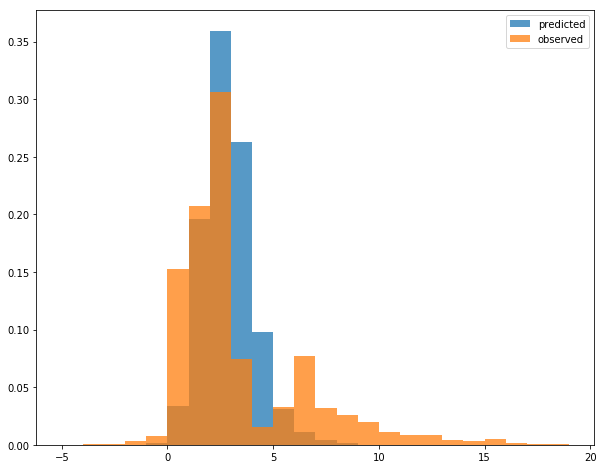

In [173]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lr_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

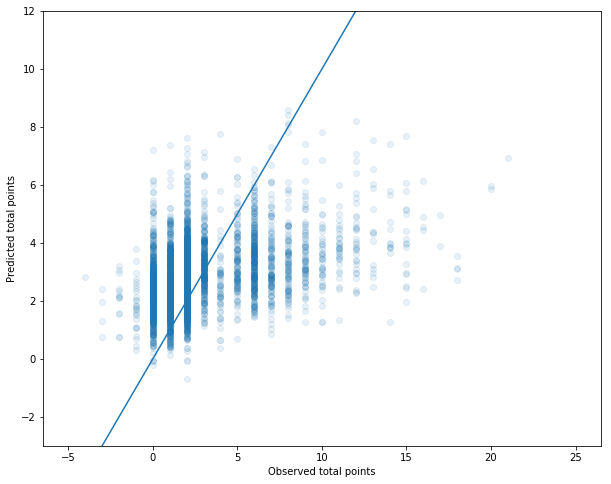

In [174]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(lr_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Ridge regression (lush)

In [213]:
lush_ridge_model = Ridge(alpha=13.8)
lush_ridge_model.fit(lush_ridge_X_train_sel, y_train.ravel())

Ridge(alpha=13.8, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [214]:
# get predictions for test set
lush_ridge_y_pred = lush_ridge_model.predict(lush_ridge_X_test_sel).flatten()

# calculate cross entropy loss for test set
lush_ridge_test_loss = (
    mean_absolute_error(y_test, lush_ridge_y_pred),
    mean_squared_error(y_test, lush_ridge_y_pred),
    r2_score(y_test, lush_ridge_y_pred),
)
lush_ridge_test_loss

(2.1822167404313126, 9.279868658737511, 0.10828981094538359)

In [215]:
# refit lush_ridge_model on all data
lush_ridge_model_full = Ridge(alpha=13.8)
lush_ridge_model_full.fit(lush_ridge_X_sel, y.ravel())

Ridge(alpha=13.8, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [216]:
# get predictions for whole set
lush_ridge_y_pred_full = lush_ridge_model_full.predict(lush_ridge_X_sel).flatten()

# calculate cross entropy loss for test set
lush_ridge_test_loss_full = (
    mean_absolute_error(y, lush_ridge_y_pred_full),
    mean_squared_error(y, lush_ridge_y_pred_full),
    r2_score(y, lush_ridge_y_pred_full)
)
lush_ridge_test_loss_full

(2.0288252233906436, 7.790818677142343, 0.1857896051467317)

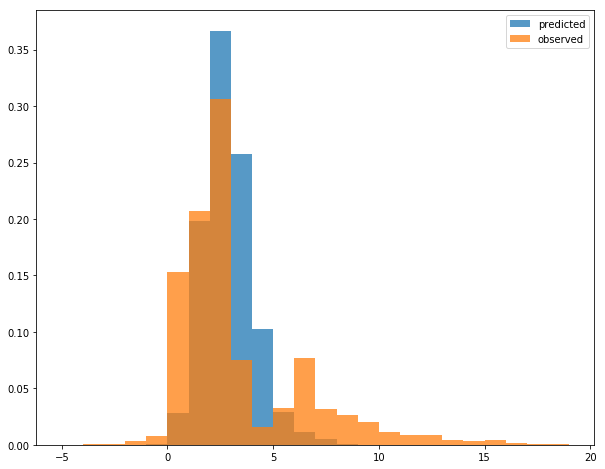

In [217]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_ridge_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

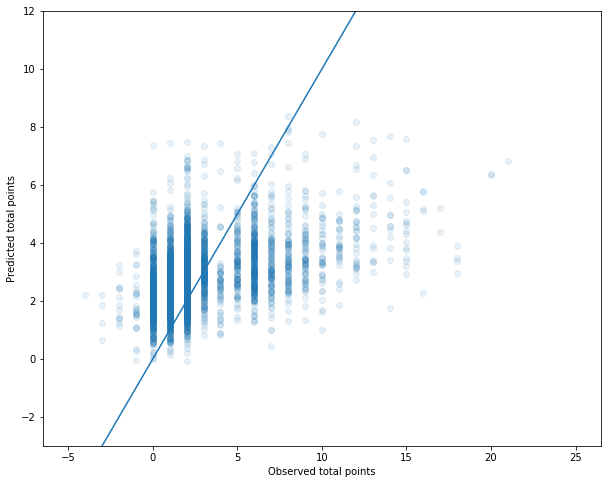

In [218]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(lush_ridge_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Ridge regression (stark)

In [230]:
stark_ridge_model = Ridge(alpha=0.36)
stark_ridge_model.fit(stark_ridge_X_train_sel, y_train.ravel())

Ridge(alpha=0.36, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [231]:
# get predictions for test set
stark_ridge_y_pred = stark_ridge_model.predict(stark_ridge_X_test_sel).flatten()

# calculate cross entropy loss for test set
stark_ridge_test_loss = (
    mean_absolute_error(y_test, stark_ridge_y_pred),
    mean_squared_error(y_test, stark_ridge_y_pred),
    r2_score(y_test, stark_ridge_y_pred)
)

stark_ridge_test_loss

(2.1917661939232715, 9.194415479727223, 0.11650107698941714)

In [232]:
# refit stark_ridge_model on all data
stark_ridge_model_full = Ridge(alpha=0.36)
stark_ridge_model_full.fit(stark_ridge_X_sel, y.ravel())

Ridge(alpha=0.36, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [233]:
# get predictions for whole set
stark_ridge_y_pred_full = stark_ridge_model_full.predict(stark_ridge_X_sel).flatten()

# calculate cross entropy loss for test set
stark_ridge_test_loss_full = (
    mean_absolute_error(y, stark_ridge_y_pred_full),
    mean_squared_error(y, stark_ridge_y_pred_full),
    r2_score(y, stark_ridge_y_pred_full))
stark_ridge_test_loss_full

(2.0632758125121313, 8.042684886783304, 0.15946732831032828)

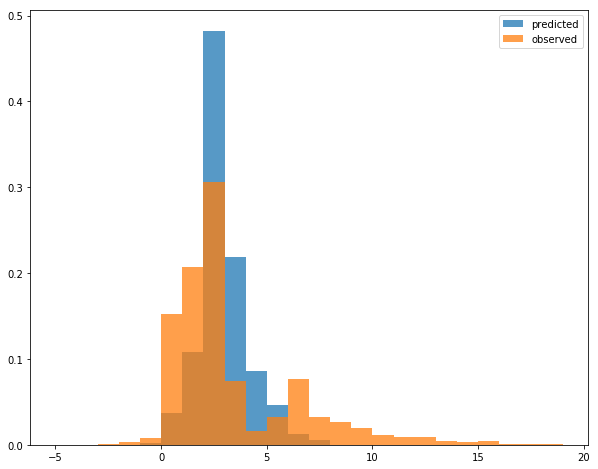

In [234]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_ridge_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

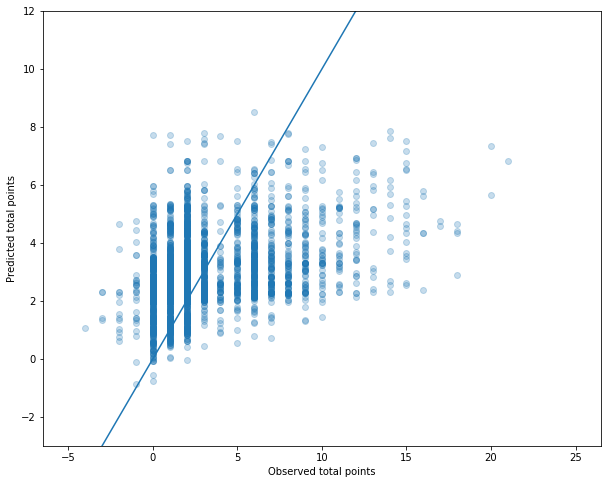

In [235]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(stark_ridge_y_pred_full), alpha=0.25)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Lasso regression

In [328]:
lasso_model = Lasso(alpha=1e-10)
lasso_model.fit(lasso_X_train_sel, y_train.ravel())

Lasso(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [329]:
# get predictions for test set
lasso_y_pred = lasso_model.predict(lasso_X_test_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss = (
    mean_absolute_error(y_test, lasso_y_pred),
    mean_squared_error(y_test, lasso_y_pred),
    r2_score(y_test, lasso_y_pred)
)
lasso_test_loss

(2.164754256334239, 9.231917190789526, 0.1128975068214545)

In [263]:
# refit lasso_model on all data
lasso_model_full = Lasso(alpha=1e-10)
lasso_model_full.fit(lasso_X_sel, y.ravel())

Lasso(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [264]:
# get predictions for whole set
lasso_y_pred_full = lasso_model_full.predict(lasso_X_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss_full = (
    mean_absolute_error(y, lasso_y_pred_full),
    mean_squared_error(y, lasso_y_pred_full),
    r2_score(y, lasso_y_pred_full)
)
lasso_test_loss_full

(2.1321503479829755, 8.51805888830823, 0.10978648352052767)

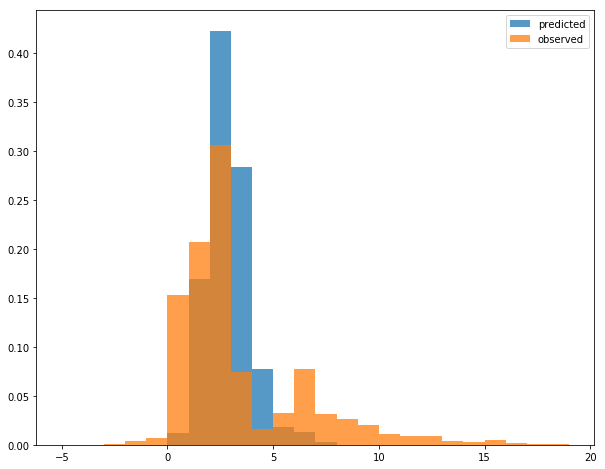

In [265]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

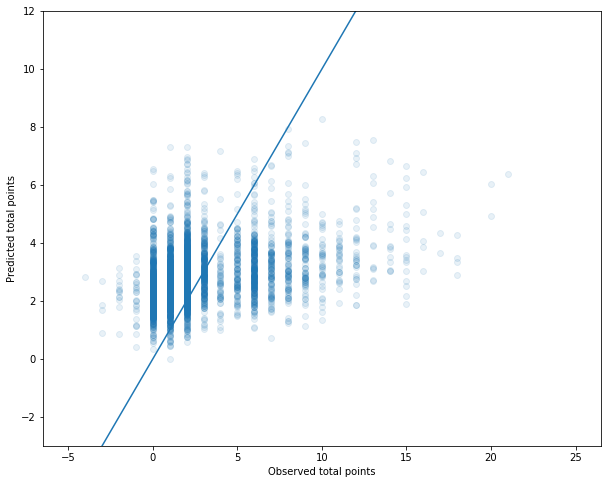

In [266]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(lasso_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [267]:
pd.DataFrame([
    ('Linear regression', lr_test_loss[0], lr_test_loss[1], lr_test_loss[2]),
    ('Ridge regression (lush)', lush_ridge_test_loss[0], lush_ridge_test_loss[1], lush_ridge_test_loss[2]),
    ('Ridge regression (stark)', stark_ridge_test_loss[0], stark_ridge_test_loss[1], stark_ridge_test_loss[2]),
    ('Lasso regression', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.186569,9.358275,0.100756
1,Ridge regression (lush),2.182217,9.279869,0.108290
2,Ridge regression (stark),2.191766,9.194415,0.116501
3,Lasso regression,2.164754,9.231917,0.112898


In [268]:
pd.DataFrame([
    ('Linear regression', lr_test_loss_full[0], lr_test_loss_full[1], lr_test_loss_full[2]),
    ('Ridge regression (lush)', lush_ridge_test_loss_full[0], lush_ridge_test_loss_full[1], lush_ridge_test_loss_full[2]),
    ('Ridge regression (stark)', stark_ridge_test_loss_full[0], stark_ridge_test_loss_full[1], stark_ridge_test_loss_full[2]),
    ('Lasso regression', lasso_test_loss_full[0], lasso_test_loss_full[1], lasso_test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.073708,8.178217,0.145303
1,Ridge regression (lush),2.028825,7.790819,0.185790
2,Ridge regression (stark),2.063276,8.042685,0.159467
3,Lasso regression,2.132150,8.518059,0.109786
